### 빅쿼리 분석

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import glob
from google.cloud import bigquery
from google.oauth2 import service_account

In [2]:
# 파이썬 구글 빅쿼리 연동 코드
# json 파일

key_path = glob.glob("./*.json")[0]
credentials = service_account.Credentials.from_service_account_file("/mnt/c/Users/82105/Desktop/이커머스 데이터 분석/e-commerce_data_analysis/data-analysis-with-olist-e5fb88210657.json")
client = bigquery.Client(credentials = credentials, 
                         project = credentials.project_id)

In [3]:
# sql 추출 및 데이터 프레임 변환

def sql_to_dataframe(sql:str) -> pd.DataFrame:
    """
    Args:
        sql (str): sql for extraction

    Returns:
        pd.DataFrame: extract data with sql
    """
    query_job = client.query(sql)
    df = query_job.to_dataframe()
    return df

#### 1. 재구매율

##### 1-1 가장 많은 주문이 발생한 제품 카테고리는 무엇일까?

In [11]:
# sql 실행

sql = f"""
SELECT product_category_name
      ,b.string_field_1 AS product_category_name_english
      ,COUNT(DISTINCT c.order_id) AS orders
      ,SUM(payment_value) AS revenue
FROM `olist.olist_products_dataset` a
LEFT JOIN `olist.olist_product_category_name_translation` b on a.product_category_name = b.string_field_0
RIGHT JOIN `olist.olist_order_items_dataset` c on a.product_id = c.product_id
LEFT JOIN `olist.olist_orders_dataset` d on c.order_id = d.order_id
LEFT JOIN  `olist.olist_order_payments_dataset` e on c.order_id = e.order_id
WHERE product_category_name IS NOT NULL
AND order_status <> "canceled"
AND order_delivered_customer_date IS NOT NULL
GROUP BY 1,2
ORDER BY revenue DESC
"""

df = sql_to_dataframe(sql)
df.head()

,product_category_name,product_category_name_english,orders,revenue
0,cama_mesa_banho,bed_bath_table,9272,1692714.28
1,beleza_saude,health_beauty,8647,1620684.04
2,informatica_acessorios,computers_accessories,6529,1549252.47
3,moveis_decoracao,furniture_decor,6307,1394466.93
4,relogios_presentes,watches_gifts,5493,1387046.31


* 가장 많은 주문이 발생한 카테고리는 bed_bath_table, health_beauty, computer_accessories 입니다.
* 따라서 위 3개 카테고리 재주문율 분석을 진행하겠습니다.

#### 1-2 bed_bath_table의 재구매율은 어떻게 될까?

고객의 유일 아이디를 활용해서 고객의 첫 구매 날짜와 마지막 구매 날짜를 구했습니다. 이 값을 활용해서 두 기간의 일자를 추출하고 주기를 구했습니다.
예를 들어 어떤 고객이 3번 구매를 했는데, 첫 구매 날짜와 마지막 구매 날짜의 차이가 8일이라면 8 / (3-1)을 해서 4일이라는 주기가 추출이 됩니다.

In [12]:
# sql 실행

sql = f"""
SELECT *
      ,CASE
        WHEN first_pur < recent_pur THEN "Y"
        ELSE "N"
      END AS repurchase
      ,DATE_DIFF(recent_pur, first_pur, day) as interval_pur
      ,CASE
        WHEN count_order = 1 OR DATE_DIFF(recent_pur, first_pur, day) = 0 THEN 0
        ELSE DATE_DIFF(recent_pur, first_pur, day) / (count_order - 1)
      END AS cycle_pur
FROM
(
  SELECT customer_unique_id
      ,MIN(order_purchase_timestamp) AS first_pur
      ,MAX(order_purchase_timestamp) AS recent_pur
      ,COUNT(DISTINCT x.order_id) AS count_order
FROM
  (
    SELECT customer_unique_id, a.order_id, order_purchase_timestamp, b.product_id
    FROM `olist.olist_orders_dataset` a
    INNER JOIN `olist.olist_order_items_dataset` b ON a.order_id = b.order_id
    INNER JOIN `olist.olist_customers_dataset` c ON a.customer_id = c.customer_id
    WHERE order_status <> "canceled"
  ) x
  INNER JOIN
  ( 
    SELECT product_id
          ,string_field_1 AS cat_name
    FROM `olist.olist_products_dataset` d
    INNER JOIN `olist.olist_product_category_name_translation` e ON d.product_category_name = e.string_field_0
  ) f
  ON x.product_id = f.product_id
  WHERE cat_name = "bed_bath_table"
  GROUP BY 1
)
"""

df = sql_to_dataframe(sql)
df.head()

,customer_unique_id,first_pur,recent_pur,count_order,repurchase,interval_pur,cycle_pur
0,60863e9f13562f664b73e6f76ff85910,2018-05-20 18:58:04+00:00,2018-05-20 18:58:04+00:00,1,N,0,0.0
1,bd62b323b8e70075724fb43aab7a5bdc,2018-01-16 17:11:07+00:00,2018-01-16 17:11:07+00:00,1,N,0,0.0
2,6b52d3725aa7cca24203308be666308b,2017-04-09 23:15:16+00:00,2017-04-09 23:15:16+00:00,1,N,0,0.0
3,58f9481a6d59f6ff267e4cdfcd8251be,2018-05-04 12:55:43+00:00,2018-05-04 12:55:43+00:00,1,N,0,0.0
4,5b0cab170035cda8b8da236cbd4be13e,2017-06-12 11:47:05+00:00,2017-06-12 11:47:05+00:00,1,N,0,0.0


In [15]:
df.loc[df["repurchase"] == "Y",]

,customer_unique_id,first_pur,recent_pur,count_order,repurchase,interval_pur,cycle_pur
27,d0bd25a13b24e8d59a11adda68bd3ecd,2017-06-28 13:20:48+00:00,2017-06-28 13:20:51+00:00,2,Y,0,0.0
35,79ff5d9ba6dc750760a809b0a84d3397,2018-03-12 10:32:11+00:00,2018-07-05 10:22:32+00:00,2,Y,114,114.0
37,2c3ed77b92cba1f5622b5ccaa1792b8b,2018-01-03 10:43:02+00:00,2018-01-27 17:01:16+00:00,2,Y,24,24.0
38,fe52c2abb172426dd6416cc69e6b3689,2017-09-16 12:30:24+00:00,2017-09-23 12:53:19+00:00,2,Y,7,7.0
42,565448508b44312e8489ca1bc1f5d09e,2017-04-20 08:47:18+00:00,2017-04-28 12:32:56+00:00,3,Y,8,4.0
...,...,...,...,...,...,...,...
8089,ecc693b513a0c362c8da8e6beeeb545a,2017-10-27 16:42:40+00:00,2018-06-19 17:43:52+00:00,2,Y,235,235.0
8645,0bdb6ad22574bad5202df1e92a9aa403,2018-02-15 19:59:58+00:00,2018-02-15 20:24:30+00:00,2,Y,0,0.0
8804,b50e2c316ac14c5ad88a269716fe3662,2018-04-08 13:04:47+00:00,2018-04-08 13:07:51+00:00,2,Y,0,0.0
9099,a176838867d89ed62981cdf02b7ca3e1,2018-03-04 15:58:09+00:00,2018-03-04 15:58:10+00:00,2,Y,0,0.0


In [18]:
df["repurchase"].value_counts(normalize=True) * 100

repurchase
N    97.5567
Y     2.4433
Name: proportion, dtype: float64

bed_bath_table의 재구매율은 2.44% 입니다. 가장 많이 구매한 카테고리인데 재구매율은 그리 높지 않습니다.

#### 1-3 health_beauty 재구매율은 어떻게 될까?

In [19]:
# sql 실행

sql = f"""
SELECT *
      ,CASE
        WHEN first_pur < recent_pur THEN "Y"
        ELSE "N"
      END AS repurchase
      ,DATE_DIFF(recent_pur, first_pur, day) as interval_pur
      ,CASE
        WHEN count_order = 1 OR DATE_DIFF(recent_pur, first_pur, day) = 0 THEN 0
        ELSE DATE_DIFF(recent_pur, first_pur, day) / (count_order - 1)
      END AS cycle_pur
FROM
(
  SELECT customer_unique_id
      ,MIN(order_purchase_timestamp) AS first_pur
      ,MAX(order_purchase_timestamp) AS recent_pur
      ,COUNT(DISTINCT x.order_id) AS count_order
FROM
  (
    SELECT customer_unique_id, a.order_id, order_purchase_timestamp, b.product_id
    FROM `olist.olist_orders_dataset` a
    INNER JOIN `olist.olist_order_items_dataset` b ON a.order_id = b.order_id
    INNER JOIN `olist.olist_customers_dataset` c ON a.customer_id = c.customer_id
    WHERE order_status <> "canceled"
  ) x
  INNER JOIN
  ( 
    SELECT product_id
          ,string_field_1 AS cat_name
    FROM `olist.olist_products_dataset` d
    INNER JOIN `olist.olist_product_category_name_translation` e ON d.product_category_name = e.string_field_0
  ) f
  ON x.product_id = f.product_id
  WHERE cat_name = "health_beauty"
  GROUP BY 1
)
"""

df = sql_to_dataframe(sql)
df.head()

,customer_unique_id,first_pur,recent_pur,count_order,repurchase,interval_pur,cycle_pur
0,cf756eabe3ad65a7f3411e595806d210,2018-01-08 21:43:10+00:00,2018-01-08 21:43:10+00:00,1,N,0,0.0
1,c0b767c6ed813d4cf17855081493f885,2018-07-11 20:24:49+00:00,2018-07-11 20:24:49+00:00,1,N,0,0.0
2,f5d97eba89503c2ea55ed36b0e8f88c2,2017-04-17 00:10:48+00:00,2017-04-17 00:10:48+00:00,1,N,0,0.0
3,0537b5ab20888f8cb3f5e2c1dec3841d,2018-05-06 07:09:28+00:00,2018-05-06 07:09:28+00:00,1,N,0,0.0
4,a324fb6c7e7c06e00ddca5cd47cab53f,2017-06-18 00:27:16+00:00,2017-06-18 00:27:16+00:00,1,N,0,0.0


In [20]:
df["repurchase"].value_counts(normalize=True) * 100

repurchase
N    98.507635
Y     1.492365
Name: proportion, dtype: float64

재구매율은 1.49%입니다.

#### 1-4 computers_accessories의 재구매율은 어떻게 될까?

In [21]:
# sql 실행

sql = f"""
SELECT *
      ,CASE
        WHEN first_pur < recent_pur THEN "Y"
        ELSE "N"
      END AS repurchase
      ,DATE_DIFF(recent_pur, first_pur, day) as interval_pur
      ,CASE
        WHEN count_order = 1 OR DATE_DIFF(recent_pur, first_pur, day) = 0 THEN 0
        ELSE DATE_DIFF(recent_pur, first_pur, day) / (count_order - 1)
      END AS cycle_pur
FROM
(
  SELECT customer_unique_id
      ,MIN(order_purchase_timestamp) AS first_pur
      ,MAX(order_purchase_timestamp) AS recent_pur
      ,COUNT(DISTINCT x.order_id) AS count_order
FROM
  (
    SELECT customer_unique_id, a.order_id, order_purchase_timestamp, b.product_id
    FROM `olist.olist_orders_dataset` a
    INNER JOIN `olist.olist_order_items_dataset` b ON a.order_id = b.order_id
    INNER JOIN `olist.olist_customers_dataset` c ON a.customer_id = c.customer_id
    WHERE order_status <> "canceled"
  ) x
  INNER JOIN
  ( 
    SELECT product_id
          ,string_field_1 AS cat_name
    FROM `olist.olist_products_dataset` d
    INNER JOIN `olist.olist_product_category_name_translation` e ON d.product_category_name = e.string_field_0
  ) f
  ON x.product_id = f.product_id
  WHERE cat_name = "computers_accessories"
  GROUP BY 1
)
"""

df = sql_to_dataframe(sql)
df.head()

,customer_unique_id,first_pur,recent_pur,count_order,repurchase,interval_pur,cycle_pur
0,7bfed641a832a3c4d47cdd36eb6eebb4,2017-07-13 11:03:05+00:00,2017-07-13 11:03:05+00:00,1,N,0,0.0
1,a8d973624c90c35a007346b82dca04c1,2018-05-11 18:24:01+00:00,2018-05-11 18:24:01+00:00,1,N,0,0.0
2,a85261827b122c9a6a1d615cb4135364,2017-10-27 12:56:40+00:00,2017-10-27 12:56:40+00:00,1,N,0,0.0
3,a4aaf2c80e3c5ffb8209fe5419e9c640,2018-04-29 13:02:12+00:00,2018-04-29 13:02:12+00:00,1,N,0,0.0
4,4578c59d3730444c9221fb635f7af881,2018-04-05 11:39:33+00:00,2018-04-05 11:39:33+00:00,1,N,0,0.0


In [22]:
df["repurchase"].value_counts(normalize=True) * 100

repurchase
N    98.282735
Y     1.717265
Name: proportion, dtype: float64

재구매율은 1.71% 입니다

### 2. 코호트 분석

#### 2-1 집단 구분 없이 기간 리텐션 분석

In [23]:
sql = """
SELECT period
      ,FIRST_VALUE(cohort_retained) over (order by period) as cohort_size
      ,cohort_retained
      ,cohort_retained * 1.0 / FIRST_VALUE(cohort_retained) over (order by period) AS pct_retained
FROM
(
  SELECT DATE_DIFF(DATETIME(order_purchase_timestamp),DATETIME(first_term),month) AS period
      ,COUNT(DISTINCT d.customer_unique_id) as cohort_retained
  FROM
  (
    SELECT b.customer_unique_id
        ,MIN(a.order_purchase_timestamp) as first_term
    FROM `olist.olist_orders_dataset` a
    LEFT JOIN `olist.olist_customers_dataset` b on a.customer_id = b.customer_id
    GROUP BY 1
  ) c
  JOIN (
    SELECT b.customer_unique_id
          ,a.order_purchase_timestamp
    FROM `olist.olist_orders_dataset` a
    LEFT JOIN `olist.olist_customers_dataset` b on a.customer_id = b.customer_id
  ) d on c.customer_unique_id = d.customer_unique_id
  GROUP BY 1
)
"""
df = sql_to_dataframe(sql)
df.head()

,period,cohort_size,cohort_retained,pct_retained
0,0,96096,96096,1.000000
1,1,96096,461,0.004797
2,2,96096,289,0.003007
3,3,96096,202,0.002102
4,4,96096,186,0.001936


![image](https://github.com/wbin0718/e-commerce_data_analysis/assets/104637982/fd218aca-8582-4d23-9ecd-0a0050a12c4b)

앞서 재구매율 분석을 했을 때 가장 많이 구매한 상품도 재구매율이 낮은 것을 볼 수 있었습니다.  
고객들이 첫 구매 이후 몇 개월 까지 구매를 이어가는지 분석하기 위해 코호트 분석을 진행하고, 구글의 looker studio를 사용해서 코호트 차트를 그렸습니다.  
코호트 분석을 통해서도 재구매율이 급격히 떨어지는 것을 볼 수가 있습니다. 수집된 데이터가 고유한 고객의 데이터가 많아서 그런 것으로 보입니다.

앞서 코호트 분석은 모든 집단을 재구매 기간으로 진행했지만, 이번에는 상품을 구매한 월별로 집단을 나누어 분석해보겠습니다.

#### 2-2 연도, 월 코호트를 집단으로 구분한 기간 리텐션 분석

In [49]:
sql = """
WITH cohort AS (
  SELECT b.customer_unique_id
      ,MIN(FORMAT_DATETIME("%Y-%m-1",order_purchase_timestamp)) AS cohort_date
  FROM `olist.olist_orders_dataset` a
  LEFT JOIN `olist.olist_customers_dataset` b ON a.customer_id = b.customer_id
  GROUP BY b.customer_unique_id
),

  cohort_size AS (
    SELECT cohort_date
          ,COUNT(DISTINCT customer_unique_id) AS cohort_cnt
    FROM cohort
    GROUP BY cohort_date
  ),

  activities AS (
    SELECT b.customer_unique_id
      ,FORMAT_DATETIME("%Y-%m-01",order_purchase_timestamp) AS activity_date
    FROM `olist.olist_orders_dataset` a
    LEFT JOIN `olist.olist_customers_dataset` b on a.customer_id = b.customer_id
  )

SELECT cohort.cohort_date
      ,DATE_DIFF(DATETIME(activity_date), DATETIME(cohort.cohort_date), month) AS month_gap
      ,cohort_cnt
      ,COUNT(DISTINCT activities.customer_unique_id) AS activity_cnt
      ,ROUND(COUNT(DISTINCT activities.customer_unique_id) * 100.0 / cohort_cnt, 2) AS retention_rate
FROM cohort
LEFT JOIN cohort_size ON cohort.cohort_date = cohort_size.cohort_date
LEFT JOIN activities ON cohort.customer_unique_id = activities.customer_unique_id
GROUP BY 1,2,3
ORDER BY 1,2
"""
df = sql_to_dataframe(sql)
df.head()

,cohort_date,month_gap,cohort_cnt,activity_cnt,retention_rate
0,2016-09-1,0,4,4,100.00
1,2016-10-1,0,321,321,100.00
2,2016-10-1,6,321,1,0.31
3,2016-10-1,9,321,1,0.31
4,2016-10-1,11,321,1,0.31


In [50]:
df_pivot_table = df.pivot_table(index="cohort_date",
               columns = "month_gap",
               values="retention_rate",
               fill_value = 0)

<Axes: xlabel='month_gap', ylabel='cohort_date'>

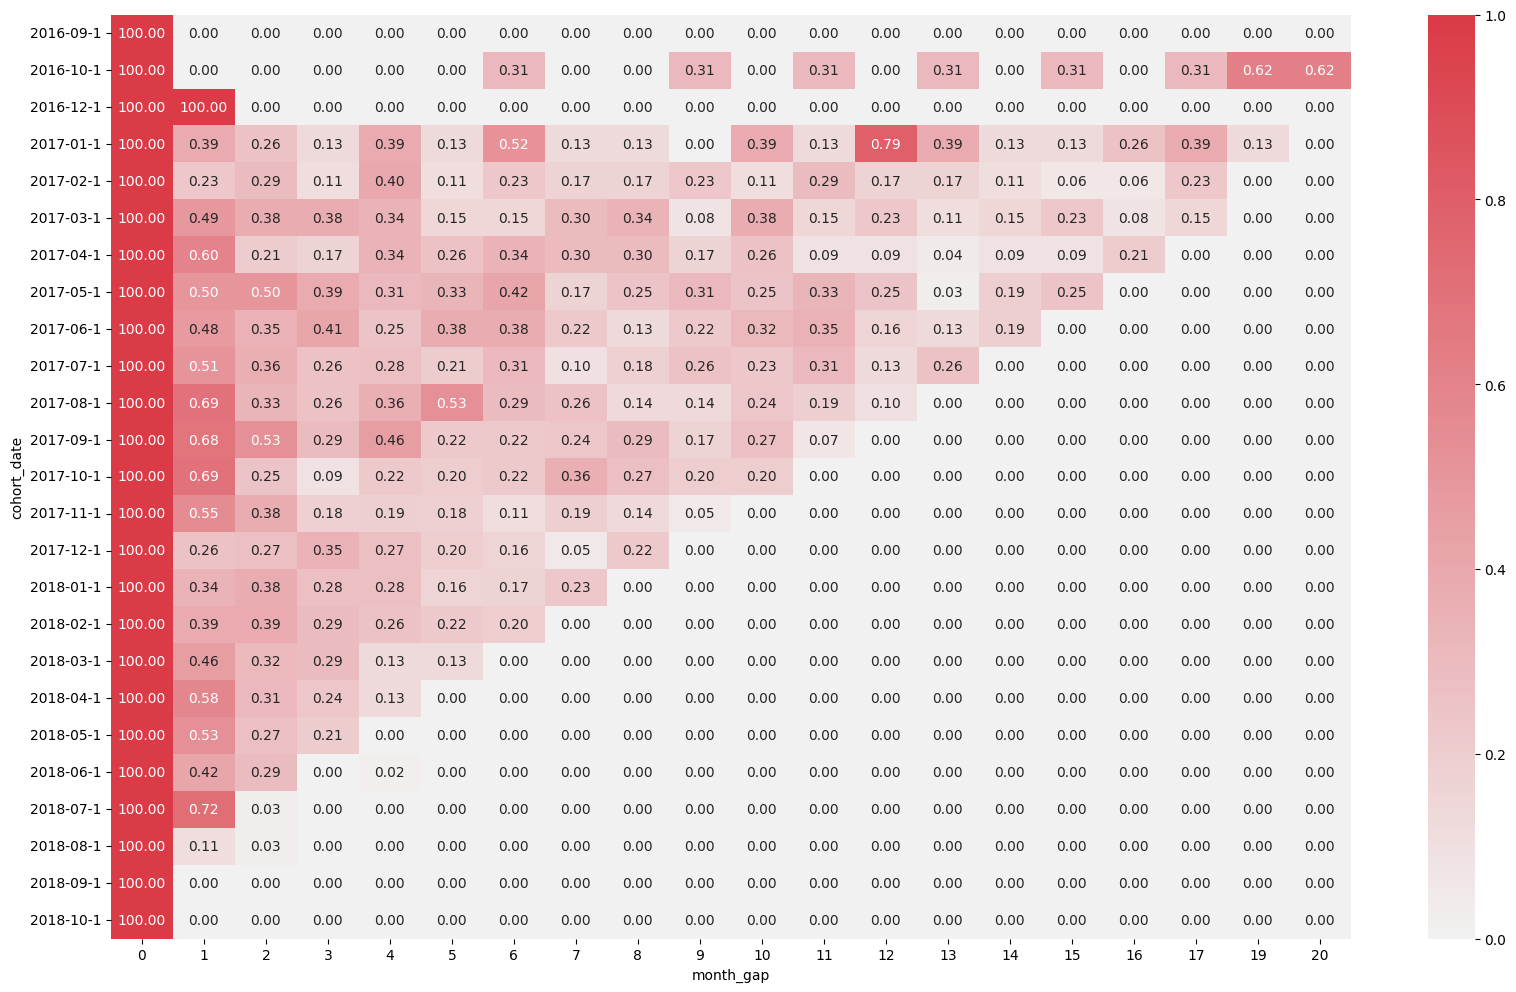

In [51]:
plt.figure(figsize=(20,12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_pivot_table,cmap=cmap,center= 0 ,vmax=1.0,square=False,annot=True,fmt=".2f")

피벗 테이블을 시각화 한 것을 보면 모든 집단이 재구매율이 낮은 것을 볼 수가 있습니다.
특히 2016년 9월, 2018년 9월, 2018년 10월은 남아있는 고객이 없는 것을 볼 수가 있습니다. 2016년 12월 고객들은 1개월 뒤 모두 재구매를 한 것으로 보입니다.


#### 2-3 연도, 분기를 활용해 30일 간격 리텐션 분석

In [52]:
sql = """
WITH cohort AS (
  SELECT b.customer_unique_id
      ,MIN(FORMAT_DATETIME("%Y-%m-1",order_purchase_timestamp)) AS cohort_date
  FROM `olist.olist_orders_dataset` a
  LEFT JOIN `olist.olist_customers_dataset` b ON a.customer_id = b.customer_id
  GROUP BY b.customer_unique_id
),

  cohort_size AS (
    SELECT cohort_date
          ,COUNT(DISTINCT customer_unique_id) AS cohort_cnt
    FROM cohort
    GROUP BY cohort_date
  ),

  activities AS (
    SELECT b.customer_unique_id
      ,FORMAT_DATETIME("%Y-%m-01",order_purchase_timestamp) AS activity_date
    FROM `olist.olist_orders_dataset` a
    LEFT JOIN `olist.olist_customers_dataset` b on a.customer_id = b.customer_id
  )

SELECT *
      ,FIRST_VALUE(activity_cnt) OVER(PARTITION BY cohort_quarter ORDER BY month_gap) AS cohort_cnt
      ,activity_cnt / FIRST_VALUE(activity_cnt) OVER(PARTITION BY cohort_quarter ORDER BY month_gap) * 100 AS retention_rate
FROM
(
  SELECT cohort_quarter
      ,CASE
        WHEN quarter_gap BETWEEN -1 AND 0 THEN "month_0"
        WHEN quarter_gap BETWEEN 1 AND 4 THEN "month_1"
        WHEN quarter_gap BETWEEN 5 AND 8 THEN "month_2"
        WHEN quarter_gap BETWEEN 9 AND 12 THEN "month_3"
        ELSE "month_4"
      END AS month_gap
      ,SUM(activity_cnt) AS activity_cnt
FROM
(
    SELECT CASE
            WHEN cohort.cohort_date BETWEEN "2017-01-01" AND "2017-03-31" THEN "2017-01"
            WHEN cohort.cohort_date BETWEEN "2017-04-01" AND "2017-06-31" THEN "2017-02"
            WHEN cohort.cohort_date BETWEEN "2017-07-01" AND "2017-09-31" THEN "2017-03"
            WHEN cohort.cohort_date BETWEEN "2017-10-01" AND "2017-12-31" THEN "2017-04"
            WHEN cohort.cohort_date BETWEEN "2018-01-01" AND "2018-03-31" THEN "2018-01"
            WHEN cohort.cohort_date BETWEEN "2018-04-01" AND "2018-06-31" THEN "2018-02"
            WHEN cohort.cohort_date BETWEEN "2018-07-01" AND "2018-09-31" THEN "2018-03"
            WHEN cohort.cohort_date BETWEEN "2018-10-01" AND "2018-12-31" THEN "2018-04"
          END AS cohort_quarter
          ,DATE_DIFF(DATETIME(activity_date),DATETIME(cohort.cohort_date),week) AS quarter_gap
          ,COUNT(DISTINCT activities.customer_unique_id) AS activity_cnt
        
    FROM cohort
    LEFT JOIN cohort_size ON cohort.cohort_date = cohort_size.cohort_date
    LEFT JOIN activities ON cohort.customer_unique_id = activities.customer_unique_id
    WHERE cohort.cohort_date BETWEEN "2017-01-01" AND "2018-12-31"
    GROUP BY 1,2
  )  cohort_week
  GROUP BY 1,2
) cohort_month
ORDER BY cohort_quarter, month_gap
"""
df = sql_to_dataframe(sql)
df.head()

,cohort_quarter,month_gap,activity_cnt,cohort_cnt,retention_rate
0,2017-01,month_0,5152,5152,100.000000
1,2017-01,month_1,20,5152,0.388199
2,2017-01,month_2,7,5152,0.135870
3,2017-01,month_3,11,5152,0.213509
4,2017-01,month_4,162,5152,3.144410


In [55]:
df_pivot_table = df.pivot_table(index="cohort_quarter",
               columns = "month_gap",
               values="retention_rate",
               fill_value = 0)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, '2017-01'),
  Text(0, 1.5, '2017-02'),
  Text(0, 2.5, '2017-03'),
  Text(0, 3.5, '2017-04'),
  Text(0, 4.5, '2018-01'),
  Text(0, 5.5, '2018-02'),
  Text(0, 6.5, '2018-03'),
  Text(0, 7.5, '2018-04')])

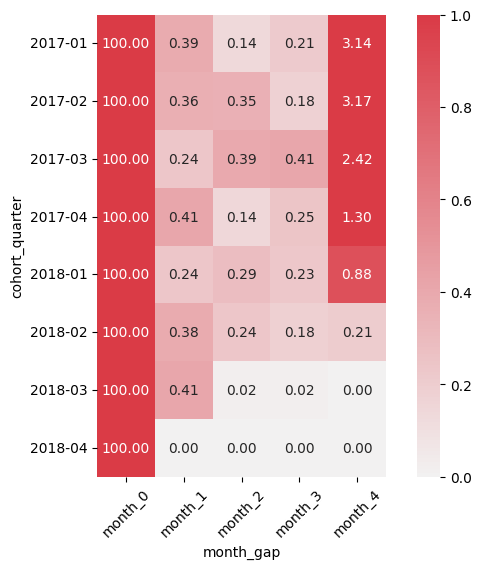

In [74]:
plt.figure(figsize=(8,6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_pivot_table,cmap=cmap,center= 0 ,vmax=1.0,square=True,annot=True,fmt=".2f")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

연도, 일 리텐션 분석을 진행했을 때 너무 많은 기간이 걸쳐져 있어 분기별, 1달~4달의 리텐션 분석을 진행했습니다.   
모든 코호트의 리텐션은 낮은 것을 볼 수가 있지만 그래도 4달 후 리텐션 값이 다른 기간보다 상대적으로 높은 것을 확인할 수 있습니다.
리텐션이 낮은 이유는 두가지 정도로 생각을 하면 될 것 같습니다.   

1. 가공된 데이터이므로 편향이 발생했다는 점 입니다.   
2. 브라질은 국내처럼 유통 환경이 좋지가 않아, 자주 주문하는 상품을 거래하는 대신 한번 구매를 하면 주기가 긴 상품들을 대상으로 해 재 리텐션이 낮은 것 입니다.